# Only true data

## (i) Importing the necessary packages

In [121]:
import numpy as np
import pandas as pd
import tensorflow
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from model_ACGAN import discriminator
import torch

In [122]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
# person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
# person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

![EEG_prep.png](attachment:EEG_prep.png)

In [123]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [124]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

# fake_GAN = np.load('GAN.npy')
# fake_WGAN = np.load('WGAN.npy')



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)



# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
Shape of training set af

## (iii)(CNN) Defining the architecture of a basic CNN model

In [125]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_48 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_49 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 28, 1, 50)      

## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [126]:
# Model parameters
learning_rate = 1e-3
epochs = 70
cnn_optimizer = tensorflow.keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## (v)(CNN) Compiling, training and validating the model

In [127]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_test, y_test), verbose=True)


Epoch 1/70
109/109 [==============================] - 2s 10ms/step - loss: 1.9489 - accuracy: 0.3391 - val_loss: 1.2595 - val_accuracy: 0.4588
Epoch 2/70
109/109 [==============================] - 1s 7ms/step - loss: 1.4797 - accuracy: 0.4092 - val_loss: 1.1899 - val_accuracy: 0.5011
Epoch 3/70
109/109 [==============================] - 1s 7ms/step - loss: 1.2942 - accuracy: 0.4605 - val_loss: 1.2044 - val_accuracy: 0.4769
Epoch 4/70
109/109 [==============================] - 1s 7ms/step - loss: 1.1850 - accuracy: 0.4993 - val_loss: 1.0848 - val_accuracy: 0.5474
Epoch 5/70
109/109 [==============================] - 1s 8ms/step - loss: 1.1019 - accuracy: 0.5415 - val_loss: 1.0808 - val_accuracy: 0.5423
Epoch 6/70
109/109 [==============================] - 1s 8ms/step - loss: 1.0380 - accuracy: 0.5675 - val_loss: 1.1042 - val_accuracy: 0.5119
Epoch 7/70
109/109 [==============================] - 1s 7ms/step - loss: 0.9857 - accuracy: 0.5967 - val_loss: 0.9811 - val_accuracy: 0.5914
Epoch

## (vi)(CNN) Visualizing the accuracy and loss trajectory

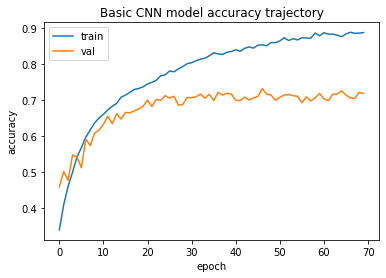

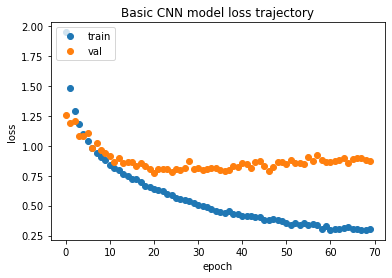

In [128]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [129]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.718397319316864


# Add fake data - ACGAN shape(N,22,250,1)


In [108]:
fake_ACGAN = np.load('ACGAN_generate_X.npy')
fake_label = np.load('generate_label.npy')

fake_ACGAN = np.swapaxes(fake_ACGAN, 1,3)
fake_ACGAN = np.swapaxes(fake_ACGAN, 1,2)

#Add 8460/4 fake data
x_train_plus = np.vstack((x_train, fake_ACGAN[0:fake_ACGAN.shape[0]//3]))
y_train_plus = np.vstack((y_train, fake_label[0:fake_ACGAN.shape[0]//3]))
p = np.random.permutation(x_train.shape[0])
x_train_plus, y_train_plus = x_train_plus[p], y_train_plus[p]

In [86]:
# Building the CNN model using sequential class
basic_cnn_model_1 = Sequential()

# Conv. block 1
basic_cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model_1.add(BatchNormalization())
basic_cnn_model_1.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model_1.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_1.add(BatchNormalization())
basic_cnn_model_1.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model_1.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_1.add(BatchNormalization())
basic_cnn_model_1.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model_1.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_1.add(BatchNormalization())
basic_cnn_model_1.add(Dropout(0.5))

# # Conv. block 5
# basic_cnn_model.add(Conv2D(filters=400, kernel_size=(10,1), padding='same', activation='elu'))
# basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# basic_cnn_model.add(BatchNormalization())
# basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model_1.add(Flatten()) # Flattens the input
basic_cnn_model_1.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model_1.summary()


# Model parameters
learning_rate = 1e-3
epochs = 70
cnn_optimizer = tensorflow.keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
basic_cnn_model_1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_1_results = basic_cnn_model_1.fit(x_train_plus,
             y_train_plus,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_test, y_test), verbose=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 28, 1, 50)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
109/109 [==============================] - 2s 10ms/step - loss: 1.9938 - accuracy: 0.3135 - val_loss: 1.3785 - val_accuracy: 0.4052
Epoch 2/70
109/109 [==============================] - 1s 7ms/step - loss: 1.5620 - accuracy: 0.3598 - val_loss: 1.3047 - val_accuracy: 0.3939
Epoch 3/70
109/109 [==============================] - 1s 8ms/step - loss: 1.3628 - accuracy: 0.4102 - val_loss: 1.2430 - val_accuracy: 0.4046
Epoch 4/70
109/109 [==============================] - 1s 8ms/step - loss: 1.2503 - accuracy: 0.4583 - val_loss: 1.1836 - val_accuracy: 0.4707
Epoch 5/70
109/109 [==============================] - 1s 8ms/step - loss: 1.1746 - accuracy: 0.4945 - val_loss: 1.1467 - val_accuracy: 0.4944
Epoch 6/70
109/109 [==============================] - 1s 8ms/step - loss: 1.0879 - accuracy: 0.5414 - val_loss: 1.1877 - val_accuracy: 0.4802
Epoch 7/70
109/109 [==============================] - 1s 8ms/step - loss: 1.0469 - accuracy: 0.5596 - val_loss: 1.0154 - val_accuracy: 0.5796
Epoch

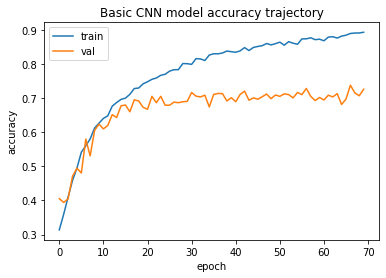

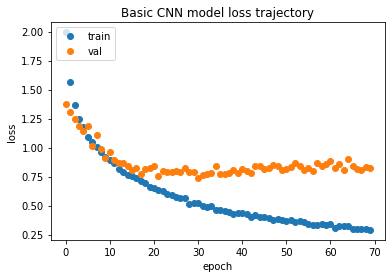

In [87]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_1_results.history['accuracy'])
plt.plot(basic_cnn_model_1_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_1_results.history['loss'],'o')
plt.plot(basic_cnn_model_1_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
## Testing the basic CNN model

cnn_score = basic_cnn_model_1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7257336378097534


#Add fake data - WGAN

In [109]:
fake_WGAN = np.load('WGAN_generate_X.npy')
fake_label = np.load('generate_label.npy')

fake_WGAN = np.swapaxes(fake_WGAN, 1,3)
fake_WGAN = np.swapaxes(fake_WGAN, 1,2)

#Add 8460/4 fake data
x_train_plus = np.vstack((x_train, fake_ACGAN[0:fake_WGAN.shape[0]//3]))
y_train_plus = np.vstack((y_train, fake_label[0:fake_WGAN.shape[0]//3]))
p = np.random.permutation(x_train.shape[0])
x_train_plus, y_train_plus = x_train_plus[p], y_train_plus[p]

# Building the CNN model using sequential class
basic_cnn_model_2 = Sequential()

# Conv. block 1
basic_cnn_model_2.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model_2.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model_2.add(BatchNormalization())
basic_cnn_model_2.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model_2.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_2.add(BatchNormalization())
basic_cnn_model_2.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model_2.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_2.add(BatchNormalization())
basic_cnn_model_2.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model_2.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_2.add(BatchNormalization())
basic_cnn_model_2.add(Dropout(0.5))

# # Conv. block 5
# basic_cnn_model.add(Conv2D(filters=400, kernel_size=(10,1), padding='same', activation='elu'))
# basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# basic_cnn_model.add(BatchNormalization())
# basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model_2.add(Flatten()) # Flattens the input
basic_cnn_model_2.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model_2.summary()


# Model parameters
learning_rate = 1e-3
epochs = 80
cnn_optimizer = tensorflow.keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
basic_cnn_model_2.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_2_results = basic_cnn_model_2.fit(x_train_plus,
             y_train_plus,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_test, y_test), verbose=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 28, 1, 50)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
109/109 [==============================] - 2s 10ms/step - loss: 2.0014 - accuracy: 0.3210 - val_loss: 1.3634 - val_accuracy: 0.3950
Epoch 2/80
109/109 [==============================] - 1s 8ms/step - loss: 1.5232 - accuracy: 0.3932 - val_loss: 1.3270 - val_accuracy: 0.4001
Epoch 3/80
109/109 [==============================] - 1s 8ms/step - loss: 1.3085 - accuracy: 0.4458 - val_loss: 1.2073 - val_accuracy: 0.4447
Epoch 4/80
109/109 [==============================] - 1s 8ms/step - loss: 1.1806 - accuracy: 0.4925 - val_loss: 1.2188 - val_accuracy: 0.4673
Epoch 5/80
109/109 [==============================] - 1s 7ms/step - loss: 1.1448 - accuracy: 0.5182 - val_loss: 1.0792 - val_accuracy: 0.5333
Epoch 6/80
109/109 [==============================] - 1s 7ms/step - loss: 1.0682 - accuracy: 0.5533 - val_loss: 1.0707 - val_accuracy: 0.5198
Epoch 7/80
109/109 [==============================] - 1s 8ms/step - loss: 1.0300 - accuracy: 0.5718 - val_loss: 1.0108 - val_accuracy: 0.5790
Epoch

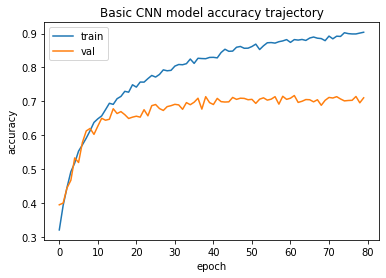

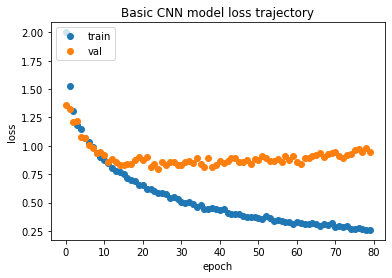

In [110]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_2_results.history['accuracy'])
plt.plot(basic_cnn_model_2_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_2_results.history['loss'],'o')
plt.plot(basic_cnn_model_2_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
## Testing the basic CNN model

cnn_score = basic_cnn_model_2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7104966044425964
